## When do we need medical experts to annotate relations between drugs and diseases?
---

In [1]:
import pandas as pd

In [2]:
labels = pd.read_csv('Expert2Relation_Mapping.csv')
excels = ['Drug-disease relations annotations - Medical Expert 1.xlsx',
          'Drug-disease relations annotations - Medical Expert 2.xlsx',
          'Drug-disease relations annotations - Medical Expert 3.xlsx']
sheets = ['Indication_treatment','indication_symptomatic_relief','contraindication', 'effect']
tables = []
for excel in excels:
    for sheet in sheets:
        df = pd.read_excel(excel, sheet_name=sheet)
        df['expert'] = excel[37:53]
        df['sheet'] = sheet
        tables.append(df)

#### Integrate

In [3]:
merged_table = pd.DataFrame()
for table in tables:
    merged_table = merged_table.append(table, ignore_index=True, sort=False)

---
### Cleaning workers inter-rate table

#### Extend worker answers from the same cell

In [4]:
#taking just one excel spreadsheet since the rest are a copy
data = merged_table[merged_table['expert']=='Medical Expert 1']

In [5]:
#rows to split
save_index = []
for idx, row in enumerate(data.iterrows()): 
    if '\n' in row[1].workers_answers:
        save_index.append(idx)

In [6]:
temp = data[data.index.isin(save_index)]
dataA = pd.merge(temp.reset_index(), 
         temp['workers_answers'].str.split('\n',expand=True).stack().rename('new').reset_index(), 
         left_on='index', 
         right_on='level_0', 
         how='outer')

dataA = dataA.drop(columns=['index','level_0','level_1','workers_answers'])\
    .rename(columns={'new':'workers_answers'})

#### Extend worker answers rows when the cell is extended

In [7]:
#now take the rest of the indexes
rest_index = list(set(list(data.index)) - set(save_index))

In [8]:
dataB = data[data.index.isin(rest_index)]\
        .fillna(method='ffill')

#### Integrate again

In [9]:
data = dataA.reset_index(drop=True).append(dataB.reset_index(drop=True), sort=False)
data = data\
    .merge(labels, how='left', left_on ='workers_answers', right_on ='Text')\
    .rename(columns={'Relation':'worker_label'})
data['value'] = 1

In [10]:
data.worker_label.unique()

array(['Indication: Treatment', 'IDK', 'Contraindication',
       'Indication: Symptomatic Relief', 'Effect'], dtype=object)

## Create a worker consensus table

In [11]:
worker_table = pd.pivot_table(
    data,
    values='value',
    index=['disease_name','drug_name','context'],
    columns=['worker_label'],
    aggfunc='sum',
    fill_value=0
).reset_index()

In [12]:
worker_table['worker_answers'] = worker_table.sum(axis=1)
worker_table['Contraindication'] = worker_table['Contraindication']/worker_table['worker_answers']
worker_table['Effect'] = worker_table['Effect']/worker_table['worker_answers']
worker_table['IDK'] = worker_table['IDK']/worker_table['worker_answers']
worker_table['Indication: Symptomatic Relief'] = worker_table['Indication: Symptomatic Relief']/worker_table['worker_answers']
worker_table['Indication: Treatment'] = worker_table['Indication: Treatment']/worker_table['worker_answers']
worker_table['perc_workers_consensus'] = worker_table.drop(columns='worker_answers').max(axis=1)

In [13]:
label_list = list(labels.Relation.unique())
label_list.remove('Inconsistent')
consensus = []
for i in range(len(worker_table)):
    if worker_table.loc[i].perc_workers_consensus > .51:
        for r in label_list:
            if worker_table.loc[i].perc_workers_consensus == worker_table.loc[i][str(r)]:
                consensus.append(str(r))
    else:
        consensus.append('No consensus')

worker_table['worker_consensus'] = consensus

In [14]:
worker_table.head()

worker_label,disease_name,drug_name,context,Contraindication,Effect,IDK,Indication: Symptomatic Relief,Indication: Treatment,worker_answers,perc_workers_consensus,worker_consensus
0,ACNE,TAZAROTENE,Retinoids may cause fetal harm when administer...,0.333333,0.666667,0.0,0.0,0.000000,3,0.666667,Effect
1,ACUTE CERVICITIS,LEVONORGESTREL,['The use of LILETTA is contraindicated when o...,0.666667,0.000000,0.0,0.0,0.333333,3,0.666667,Contraindication
2,ACUTE INTERMITTENT PORPHYRIA,Hemin,PANHEMATIN is a hemin for injection indicated ...,0.000000,0.000000,0.0,0.5,0.500000,4,0.500000,No consensus
3,ACUTE LYMPHOBLASTIC LEUKEMIA,Vincristine,Marqibo is a vinca alkaloid indicated for the ...,0.000000,0.000000,0.0,0.0,1.000000,6,1.000000,Indication: Treatment
4,ACUTE LYMPHOCYTIC LEUKEMIA,CYTARABINE,Cytarabine Injection in combination with other...,0.000000,0.000000,0.0,0.0,1.000000,6,1.000000,Indication: Treatment


In [15]:
worker_table.shape

(367, 11)

---
## Gathering experts tables

In [16]:
merged_table.expert.unique()

array(['Medical Expert 1', 'Medical Expert 2', 'Medical Expert 3'],
      dtype=object)

In [17]:
merged_table = merged_table.merge(labels, 
           how='left', left_on ='medical_expert', right_on ='Text') #add the correct labels

In [18]:
merged_table.Relation.unique()

array(['Indication: Treatment', 'Indication: Symptomatic Relief',
       'Contraindication', 'Inconsistent', nan, 'Effect', 'IDK'],
      dtype=object)

In [19]:
subset = merged_table[['disease_name','drug_name','context','expert','Relation']]\
    .rename(columns={'Relation':'expert_label'})\
    .dropna()
subset['value'] = 1
subset.drop_duplicates(keep='first', inplace=True)

## Create an expert consensus table

In [20]:
expert_table = pd.pivot_table(
    subset,
    values='value',
    index=['disease_name','drug_name','context'],
    columns=['expert_label'],
    aggfunc='sum',
    fill_value=0
).reset_index().drop(columns=['Inconsistent'])

In [21]:
expert_table['expert_answers'] = expert_table.sum(axis=1)
expert_table['Contraindication'] = expert_table['Contraindication']/expert_table['expert_answers']
expert_table['Effect'] = expert_table['Effect']/expert_table['expert_answers']
expert_table['IDK'] = expert_table['IDK']/expert_table['expert_answers']
expert_table['Indication: Symptomatic Relief'] = expert_table['Indication: Symptomatic Relief']/expert_table['expert_answers']
expert_table['Indication: Treatment'] = expert_table['Indication: Treatment']/expert_table['expert_answers']
expert_table['perc_experts_consensus'] = expert_table.drop(columns='expert_answers').max(axis=1)

In [22]:
label_list = list(labels.Relation.unique())
label_list.remove('Inconsistent')
consensusE = []
for i in range(len(expert_table)):
    if expert_table.loc[i].perc_experts_consensus > .51:
        for r in label_list:
            if expert_table.loc[i].perc_experts_consensus == expert_table.loc[i][str(r)]:
                consensusE.append(str(r))
    else:
        consensusE.append('No consensus')

expert_table['expert_consensus'] = consensusE

In [23]:
expert_table.head()

expert_label,disease_name,drug_name,context,Contraindication,Effect,IDK,Indication: Symptomatic Relief,Indication: Treatment,expert_answers,perc_experts_consensus,expert_consensus
0,ACNE,TAZAROTENE,Retinoids may cause fetal harm when administer...,0.0,0.0,0.0,0.000000,1.000000,2,1.000000,Indication: Treatment
1,ACUTE CERVICITIS,LEVONORGESTREL,['The use of LILETTA is contraindicated when o...,1.0,0.0,0.0,0.000000,0.000000,2,1.000000,Contraindication
2,ACUTE INTERMITTENT PORPHYRIA,Hemin,PANHEMATIN is a hemin for injection indicated ...,0.0,0.0,0.0,0.666667,0.333333,3,0.666667,Indication: Symptomatic Relief
3,ACUTE LYMPHOBLASTIC LEUKEMIA,Vincristine,Marqibo is a vinca alkaloid indicated for the ...,0.0,0.0,0.0,0.000000,1.000000,3,1.000000,Indication: Treatment
4,ACUTE LYMPHOCYTIC LEUKEMIA,CYTARABINE,Cytarabine Injection in combination with other...,0.0,0.0,0.0,0.000000,1.000000,3,1.000000,Indication: Treatment


In [24]:
expert_table.shape

(367, 11)

---
## Workers vs experts (merging consensus tables)

In [25]:
match_table = pd.merge(worker_table.drop(columns=label_list),
                       expert_table.drop(columns=label_list),
                       on=['disease_name','drug_name','context'], how='inner')

match_table['relation_match'] = match_table.worker_consensus == match_table.expert_consensus

In [26]:
match_table.head(4)

,disease_name,drug_name,context,worker_answers,perc_workers_consensus,worker_consensus,expert_answers,perc_experts_consensus,expert_consensus,relation_match
0,ACNE,TAZAROTENE,Retinoids may cause fetal harm when administer...,3,0.666667,Effect,2,1.000000,Indication: Treatment,False
1,ACUTE CERVICITIS,LEVONORGESTREL,['The use of LILETTA is contraindicated when o...,3,0.666667,Contraindication,2,1.000000,Contraindication,True
2,ACUTE INTERMITTENT PORPHYRIA,Hemin,PANHEMATIN is a hemin for injection indicated ...,4,0.500000,No consensus,3,0.666667,Indication: Symptomatic Relief,False
3,ACUTE LYMPHOBLASTIC LEUKEMIA,Vincristine,Marqibo is a vinca alkaloid indicated for the ...,6,1.000000,Indication: Treatment,3,1.000000,Indication: Treatment,True


In [27]:
match_table.shape

(367, 10)

---
### Check matches and workers accuracy

In [28]:
from pycm import *
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
match_table_filtered = match_table[(match_table.worker_consensus != 'No consensus') & 
                                    (match_table.expert_consensus != 'No consensus') &
                                    (match_table.worker_consensus != 'IDK') &
                                    (match_table.expert_consensus != 'IDK')]

In [30]:
y_actu = list(match_table_filtered.expert_consensus) #gold standard # X axis
y_pred = list(match_table_filtered.worker_consensus) #workers answers Y axis
cm = ConfusionMatrix(y_actu, y_pred) 

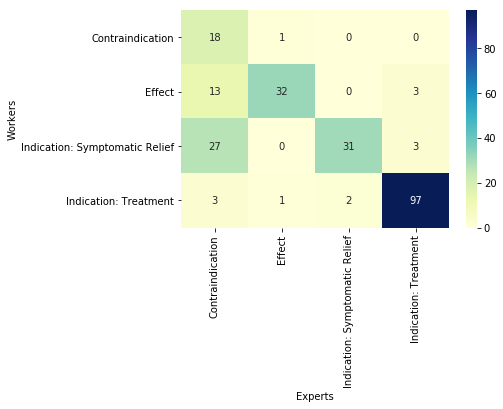

In [31]:
sns.heatmap(pd.DataFrame(cm.table), annot=True, cmap="YlGnBu")
plt.xlabel('Experts'); plt.ylabel('Workers'); plt.show()

In [32]:
cm.ACC

{'Contraindication': 0.8095238095238095,
 'Effect': 0.922077922077922,
 'Indication: Symptomatic Relief': 0.8614718614718615,
 'Indication: Treatment': 0.948051948051948}

**Workers find more diffult to annotate contraindication the most**

In [33]:
print('Workers were as good as medical experts in {}% of the cases'.format(round(cm.Overall_ACC*100,2)))

Workers were as good as medical experts in 77.06% of the cases


---
## Questions:
### - What are the characteristics of contexts that makes diffucult for the crowd to have consensus?
### - Can we train a ML method that learns when the crowd will perform as good as the experts?

Temptative features to be extracted
- lenght of text
- number of words
- particular words used on medical domain misinterpreted
- amount of medical terminology
- multiple concepts at once
- long distance between disease, drug and relation

Tenmptative groups to analyze
- Excluding the No concensus of the experts, analyze the miss match of workers
- All those answers with match, compare the label match vs concensus match
- Where do experts disagree but workers don't

---

In [34]:
#text lenght
match_table['total_characters'] = [len(text) for text in match_table['context']]
match_table['total_words'] = [len(text.replace('\n',' ').split()) for text in match_table['context']]

In [35]:
#match_table.to_csv('experts_vs_crowd_working_table.csv',index=False)

In [36]:
subset_consensus = match_table[(match_table.expert_consensus != 'No consensus') & (match_table.expert_consensus != 'IDK')]

In [37]:
subset_consensus.groupby('relation_match').describe().T#.reset_index()

relation_match                      False        True 
worker_answers         count   113.000000   178.000000
                       mean      3.637168     5.084270
                       std       1.225196     3.197577
                       min       3.000000     3.000000
                       25%       3.000000     3.000000
                       50%       3.000000     6.000000
                       75%       4.000000     6.000000
                       max      12.000000    34.000000
perc_workers_consensus count   113.000000   178.000000
                       mean      0.626991     0.915927
                       std       0.244039     0.140984
                       min       0.333333     0.666667
                       25%       0.500000     0.800000
                       50%       0.500000     1.000000
                       75%       0.800000     1.000000
                       max       1.000000     1.000000
expert_answers         count   113.000000   178.000000
                       mean      2.495575     2.505618
                       std       0.628546     0.544590
                       min       1.000000     1.000000
                       25%       2.000000     2.000000
                       50%       3.000000     3.000000
                       75%       3.000000     3.000000
                       max       5.000000     3.000000
perc_experts_consensus count   113.000000   178.000000
                       mean      0.899115     0.971910
                       std       0.154590     0.092858
                       min       0.600000     0.666667
                       25%       0.666667     1.000000
                       50%       1.000000     1.000000
                       75%       1.000000     1.000000
                       max       1.000000     1.000000
total_characters       count   113.000000   178.000000
                       mean    990.619469   963.039326
                       std     725.005435   748.894963
                       min     109.000000    81.000000
                       25%     435.000000   409.750000
                       50%     805.000000   680.000000
                       75%    1427.000000  1260.500000
                       max    3060.000000  3511.000000
total_words            count   113.000000   178.000000
                       mean    131.345133   129.528090
                       std      96.390275    98.882638
                       min      13.000000    11.000000
                       25%      58.000000    54.000000
                       50%      99.000000    98.500000
                       75%     183.000000   172.000000
                       max     380.000000   393.000000

## Statistical difference in means

In [38]:
subset_matches = subset_consensus[subset_consensus['relation_match']==True]
subset_missmatches = subset_consensus[subset_consensus['relation_match']==False]

In [39]:
from scipy import stats

Ttest_indResult(statistic=0.0, pvalue=1.0)

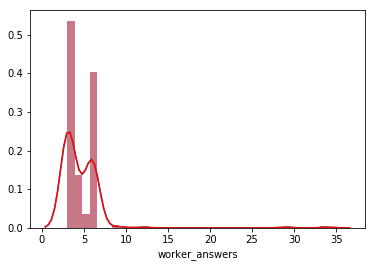

In [40]:
# T-test with different means, variance, and n:
workers_succeed = subset_consensus.worker_answers
workers_failed = subset_consensus.worker_answers
sns.distplot(workers_succeed)
sns.distplot(workers_failed, color='r')
stats.ttest_ind(workers_succeed, workers_failed, equal_var = False)

**Workers perform as good as experts when more people answer the same task**

Ttest_indResult(statistic=0.0, pvalue=1.0)

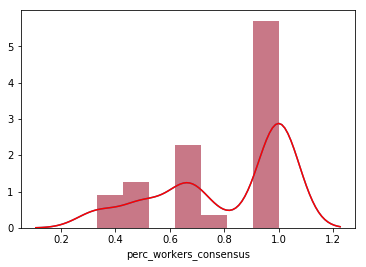

In [41]:
# T-test with different means, variance, and n:
workers_succeed = subset_consensus.perc_workers_consensus
workers_failed = subset_consensus.perc_workers_consensus
sns.distplot(workers_succeed)
sns.distplot(workers_failed, color='r')
stats.ttest_ind(workers_succeed, workers_failed, equal_var = False)

**Workers perform as good as experts when there is more agreement among workers**

Ttest_indResult(statistic=0.0, pvalue=1.0)

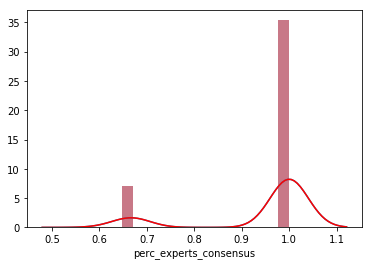

In [42]:
# T-test with different means, variance, and n:
workers_succeed = subset_consensus.perc_experts_consensus
workers_failed = subset_consensus.perc_experts_consensus
sns.distplot(workers_succeed)
sns.distplot(workers_failed, color='r')
stats.ttest_ind(workers_succeed, workers_failed, equal_var = False)

**It does not matter the level of agreement of the experts on workers successes**

Ttest_indResult(statistic=0.0, pvalue=1.0)

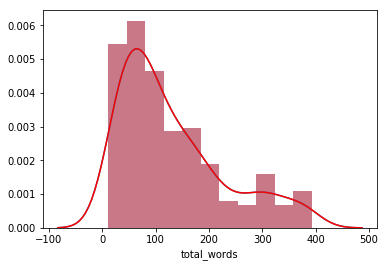

In [43]:
# T-test with different means, variance, and n:
workers_succeed = subset_consensus.total_words
workers_failed = subset_consensus.total_words
sns.distplot(workers_succeed)
sns.distplot(workers_failed, color='r')
stats.ttest_ind(workers_succeed, workers_failed, equal_var = False)

**It does not matter the number of words in the text on workers successes**

Ttest_indResult(statistic=0.0, pvalue=1.0)

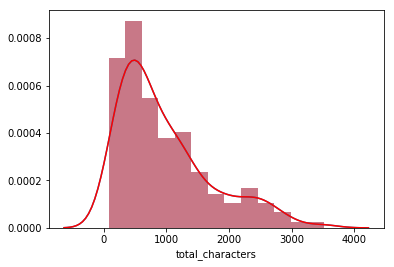

In [44]:
# T-test with different means, variance, and n:
workers_succeed = subset_consensus.total_characters
workers_failed = subset_consensus.total_characters
sns.distplot(workers_succeed)
sns.distplot(workers_failed, color='r')
stats.ttest_ind(workers_succeed, workers_failed, equal_var = False)

**It does not matter the lenght of characters in the text on workers successes**

---
### Can we predict the crowd will perform as good as an expert based on the features

In [45]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# split data into X and y
X = subset_consensus._get_numeric_data().drop(columns=['relation_match','perc_experts_consensus','expert_answers'])
Y = subset_consensus['relation_match']
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.26%


In [46]:
cmx = ConfusionMatrix([float(i ==True) for i in y_test], list(predictions)) 

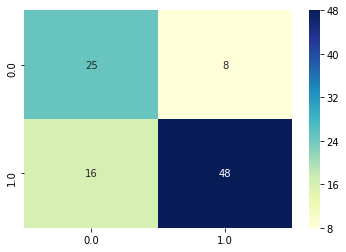

In [47]:
sns.heatmap(pd.DataFrame(cmx.table), annot=True, cmap="YlGnBu")